# DeepRAP pipeline

In [1]:
import copy
import os
import nibabel as nib
import gdown
import warnings
import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
import scipy.optimize
import scipy.ndimage
import skimage.exposure
import skimage.morphology
import torch
from torch import nn
import torch.nn.functional
import time
import networkx as nx
import json
from matplotlib.cm import ScalarMappable

In [2]:
FILE_PREFIX = "."

input_file = os.path.join(FILE_PREFIX, "R_20190430164629_Stefan_LF.npy.npz")
model_file_layerseg = os.path.join(FILE_PREFIX, "mod210616-00_last_.pt")
model_file_vesselseg = os.path.join(FILE_PREFIX, "mod210702-01.pt")

# only works with this specific version of gdown
# !pip install gdown==4.6.0
assert gdown.__version__ == "4.6.0"

if not os.path.exists(input_file):
    gdown.download(id="1oV3cr4YJlGsfhxkOwW4PEcMi6DOLNEXC", output=input_file, quiet=False)
if not os.path.exists(model_file_layerseg):
    gdown.download(id="1lLEhdOQXMWMH_dxRd9_VNcFNO_8tisMd", output=model_file_layerseg, quiet=False)
if not os.path.exists(model_file_vesselseg):
    gdown.download(id="1SDhvfDOCJ30_7RpDg7JV_GfI5akdoss6", output=model_file_vesselseg, quiet=False)

data = np.load(input_file)
raw_rsom_lf = data["lf"]
raw_rsom_hf = data["hf"]

## Layer Segmentation
### Preprocessing

Calculate the maximum intensity projection for visualization

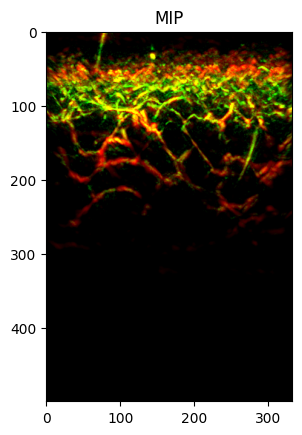

In [3]:
def calculate_mip(vol_lf: ndarray, vol_hf: ndarray, axis: int = 1) -> ndarray:
    # maximum intensity projection
    mip_lf = np.amax(vol_lf, axis=axis)
    mip_hf = np.amax(vol_hf, axis=axis)

    # calculate scaling factor alpha in between lf and hf channel
    # to maximize contrast
    alpha = scipy.optimize.minimize_scalar(
        lambda x: np.sum(np.square(mip_lf - x * mip_hf)),
        bounds=(0, 100),
        method="bounded",
    ).x

    mip_rgb = np.dstack([mip_lf, alpha * mip_hf, np.zeros_like(mip_lf)])
    mip_rgb = mip_rgb.clip(0, np.inf)
    mip_rgb = skimage.exposure.rescale_intensity(mip_rgb, out_range=np.uint8).astype(
        np.uint8
    )
    quantiles = np.quantile(mip_rgb, (0.8, 0.9925))
    mip_rgb = skimage.exposure.rescale_intensity(
        mip_rgb, in_range=(quantiles[0], quantiles[1]), out_range=np.uint8
    )
    return mip_rgb


mip_rgb = calculate_mip(raw_rsom_lf, raw_rsom_hf)
plt.figure()
plt.imshow(mip_rgb)
plt.title("MIP")
plt.show()

Prepare the volume by applying the intensity transformations.

In [4]:
def prepare_rgb_volume(
    vol_lf: ndarray, vol_hf: ndarray, upper_bound: dict, lower_bound: dict
) -> ndarray:
    vol_lf_norm = vol_lf / np.amax(vol_lf)
    vol_hf_norm = vol_hf / np.amax(vol_hf)

    vol_lf_norm = np.clip(vol_lf_norm, 0, 1)
    vol_hf_norm = np.clip(vol_hf_norm, 0, 1)

    vol_lf_norm = skimage.exposure.rescale_intensity(
        vol_lf_norm, in_range=(0, upper_bound["lf"])
    )
    vol_hf_norm = skimage.exposure.rescale_intensity(
        vol_hf_norm, in_range=(0, upper_bound["hf"])
    )

    # square
    vol_lf_norm = vol_lf_norm**2
    vol_hf_norm = vol_hf_norm**2

    vol_lf_norm = skimage.exposure.rescale_intensity(
        vol_lf_norm, in_range=(lower_bound["lf"], 1)
    )
    vol_hf_norm = skimage.exposure.rescale_intensity(
        vol_hf_norm, in_range=(lower_bound["hf"], 1)
    )

    vol_rgb = 255 * np.stack(
        [vol_lf_norm, vol_hf_norm, np.zeros_like(vol_lf_norm)], axis=-1
    )
    return vol_rgb.astype(np.uint8)


vol_rgb = prepare_rgb_volume(
    raw_rsom_lf,
    raw_rsom_hf,
    upper_bound={"lf": 0.2, "hf": 0.1},
    lower_bound={"lf": 0.05, "hf": 0.02},
)

Prepare the tensor by applying the sliding window maximum intensity projection and converting to the correct type and shape.

Additionally, define the inverse function to transform the tensor back into a numpy array.

In [5]:
def prepare_tensor(data, sliding_window_size):
    def sliding_window_mip(data, sliding_window_size):
        data_mip_x = scipy.ndimage.maximum_filter1d(
            data, size=sliding_window_size, axis=1
        )
        data_mip_y = scipy.ndimage.maximum_filter1d(
            data, size=sliding_window_size, axis=2
        )

        return data_mip_x, data_mip_y

    data_sliding_mip_x, data_sliding_mip_y = sliding_window_mip(
        data, sliding_window_size
    )

    # 500 to axis 1
    data_sliding_mip_x = np.swapaxes(data_sliding_mip_x, 0, 1)
    # 500 to axis 1
    data_sliding_mip_y = np.swapaxes(data_sliding_mip_y, 0, 1)
    # swap
    data_sliding_mip_y = np.swapaxes(data_sliding_mip_y, 0, 2)

    class Crop:
        def __init__(self, unet_depth):
            self.maxdiv = 2 ** (unet_depth - 1)

        def __call__(self, data, meta):
            # easy version: first crop to even, crop rest afterwards, if necessary
            initial_dshape = data.shape

            is_odd = np.mod(data.shape[:-1], 2)

            # batch dimension is first dimension
            data = data[:, is_odd[1] :, is_odd[2] :, :]

            # save, how much data was cropped
            meta["crop"] = {}
            meta["crop"]["begin"] = np.array([0, is_odd[1], is_odd[2], 0], dtype=int)
            meta["crop"]["end"] = np.array([0, 0, 0, 0], dtype=int)

            # check if Z and Y are divisible through self.maxdiv
            rem1 = np.mod(data.shape[1], self.maxdiv)
            rem2 = np.mod(data.shape[2], self.maxdiv)

            if rem1 or rem2:
                if rem1:
                    # crop Z
                    data = data[
                        :, int(np.floor(rem1 / 2)) : -int(np.ceil(rem1 / 2)), :, :
                    ]

                if rem2:
                    # crop Y
                    data = data[
                        :, :, int(np.floor(rem2 / 2)) : -int(np.ceil(rem2 / 2)), :
                    ]

                # add to meta information, how much has been cropped
                meta["crop"]["begin"] += np.array(
                    [0, np.floor(rem1 / 2), np.floor(rem2 / 2), 0], dtype=int
                )
                meta["crop"]["end"] += np.array(
                    [0, np.ceil(rem1 / 2), np.ceil(rem2 / 2), 0], dtype=int
                )

            assert np.all(
                np.array(initial_dshape)
                == meta["crop"]["begin"] + meta["crop"]["end"] + np.array(data.shape)
            ), "Shapes and Crop do not match"
            return data, meta

    class ToTensor:
        """
        Convert np.ndarray to Tensor.
        """

        def __init__(self):
            pass

        def __call__(self, data, meta):
            # drop blue channel, it is empty
            if data.shape[-1] == 3:
                data = data[..., :2]

            # move channel axis
            data = np.moveaxis(data, -1, 1)

            data = torch.from_numpy(data)

            return data.contiguous(), meta

    meta_x = {"batch_axis": "x"}
    meta_y = {"batch_axis": "y"}
    for transform in [Crop(unet_depth=5), ToTensor()]:
        data_sliding_mip_x, meta_x = transform(data_sliding_mip_x, meta_x)
        data_sliding_mip_y, meta_y = transform(data_sliding_mip_y, meta_y)

    return data_sliding_mip_x, meta_x, data_sliding_mip_y, meta_y


def to_numpy(volume, meta):
    if not isinstance(volume, np.ndarray):
        assert isinstance(volume, torch.Tensor)
        volume = volume.numpy()

    volume = np.squeeze(volume, axis=1)

    # add padding from meta['crop']
    # structure for np.pad
    # (before0, after0), (before1, after1), ..)

    b = (meta["crop"]["begin"]).squeeze()[:-1]
    e = (meta["crop"]["end"]).squeeze()[:-1]

    pad_width = list(zip(b, e))

    volume = np.pad(volume, pad_width, "edge")

    batch_axis = meta["batch_axis"]
    if isinstance(batch_axis, list):
        batch_axis = batch_axis[0]

    if batch_axis == "x":
        volume = volume.transpose((1, 0, 2))
    elif batch_axis == "y":
        volume = volume.transpose((1, 2, 0))
    else:
        raise AttributeError

    return np.ascontiguousarray(volume)


data_x, meta_x, data_y, meta_y = prepare_tensor(vol_rgb, sliding_window_size=5)

Now check the shapes of our input data for the layer segmentation. We have two inputs, one for each direction of the skin plane.

In [6]:
print(data_x.shape)
print(data_y.shape)

torch.Size([171, 2, 496, 320])
torch.Size([333, 2, 496, 160])


### Layer Segmentation Model

Define the layer segmentation model (UNet)

In [7]:
# https://github.com/jvanvugt/pytorch-unet
# Adapted from https://discuss.pytorch.org/t/unet-implementation/426


class UNet(nn.Module):
    def __init__(
        self,
        in_channels=1,
        n_classes=2,
        depth=5,
        wf=6,
        padding=False,
        batch_norm=False,
        up_mode="upconv",
        dropout=False,
    ):
        """
        Implementation of
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        (Ronneberger et al., 2015)
        https://arxiv.org/abs/1505.04597

        Using the default arguments will yield the exact version used
        in the original paper

        Args:
            in_channels (int): number of input channels
            n_classes (int): number of output channels
            depth (int): depth of the network
            wf (int): number of filters in the first layer is 2**wf
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
                            This may introduce artifacts
            batch_norm (bool): Use BatchNorm after layers with an
                                activation function
            up_mode (str): one of 'upconv' or 'upsample'.
                            'upconv' will use transposed convolutions for
                            learned upsampling.
                            'upsample' will use bilinear upsampling.
            dropout (bool) if True, add dropout layer in up block
        """
        super(UNet, self).__init__()
        assert up_mode in ("upconv", "upsample")
        self.padding = padding
        self.depth = depth
        self.dropout = dropout
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(
                UNetConvBlock(prev_channels, 2 ** (wf + i), padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            if self.dropout and i < depth - 2:
                self.up_path.append(
                    UNetUpBlock(
                        prev_channels, 2 ** (wf + i), up_mode, padding, batch_norm, True
                    )
                )
            else:
                self.up_path.append(
                    UNetUpBlock(
                        prev_channels,
                        2 ** (wf + i),
                        up_mode,
                        padding,
                        batch_norm,
                        False,
                    )
                )
            prev_channels = 2 ** (wf + i)

        self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)

    def forward(self, x):
        blocks = []
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path) - 1:
                blocks.append(x)
                x = torch.nn.functional.max_pool2d(x, 2)

        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i - 1])

        return self.last(x)

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm):
        super(UNetConvBlock, self).__init__()
        block = []

        block.append(nn.Conv2d(in_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        block.append(nn.Conv2d(out_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        return self.block(x)


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm, dropout):
        super(UNetUpBlock, self).__init__()
        if up_mode == "upconv":
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2)
        elif up_mode == "upsample":
            self.up = nn.Sequential(
                nn.Upsample(mode="bilinear", scale_factor=2, align_corners=True),
                nn.Conv2d(in_size, out_size, kernel_size=1),
            )

        self.is_dropout = dropout
        self.dropout = nn.Dropout(p=0.5)

        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm)

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[
            :, :, diff_y : (diff_y + target_size[0]), diff_x : (diff_x + target_size[1])
        ]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out = torch.cat([up, crop1], 1)
        if self.is_dropout:
            out = self.dropout(out)
        else:
            pass
        out = self.conv_block(out)
        return out


model = UNet(
    in_channels=2,
    n_classes=1,
    depth=5,
    wf=6,
    padding=True,
    batch_norm=True,
    up_mode="upconv",
    dropout=True,  # not relevant for predict
)

if torch.cuda.is_available():
    model.load_state_dict(torch.load(model_file_layerseg))
else:
    model.load_state_dict(torch.load(model_file_layerseg, map_location=torch.device('cpu')))

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# cuda_dtype = torch.bfloat16
cuda_dtype = torch.float32

batch_size = 2

model.to(device, cuda_dtype)

/home/stefan/code/deepRAP/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


UNet(
  (down_path): ModuleList(
    (0): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU()
        (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU()
        (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): UNetConvBlock(
      (block): Sequential(
        (0): C

Define the inference function and run layer segmentation prediction on the example dataset.

In [8]:
def predict(*, data_x, meta_x, data_y, meta_y, model):
    def _predict_one(batch, model):
        batch = batch.to(device, cuda_dtype)

        # divide into minibatches
        minibatches = np.arange(batch.shape[0], step=batch_size)

        # init empty prediction stack
        shp = batch.shape
        # [0 x 2 x 500 x 332]
        prediction_stack = torch.zeros(
            (0, 1, shp[2], shp[3]), dtype=cuda_dtype, requires_grad=False
        )

        for _, idx in enumerate(minibatches):
            data = batch[idx : idx + batch_size, ...]
            prediction = model(data)

            prediction = prediction.detach()
            prediction = prediction.to("cpu")
            prediction_stack = torch.cat((prediction_stack, prediction), dim=0)

        # transform -> labels
        prediction_stack = torch.sigmoid(prediction_stack.float())

        return prediction_stack

    pred_tensor_x = _predict_one(batch=data_x, model=model)
    prob_x = to_numpy(pred_tensor_x, meta_x)
    pred_tensor_y = _predict_one(batch=data_y, model=model)
    prob_y = to_numpy(pred_tensor_y, meta_y)
    combined = (prob_x + prob_y) / 2

    return combined


epidermis_prob = predict(
    data_x=data_x, meta_x=meta_x, data_y=data_y, meta_y=meta_y, model=model
)

# set decision boundary to 0.5
is_epidermis = epidermis_prob >= 0.5

### Layer Segmentation Results

Visualize the segmentation result with a semitransparent overlay.

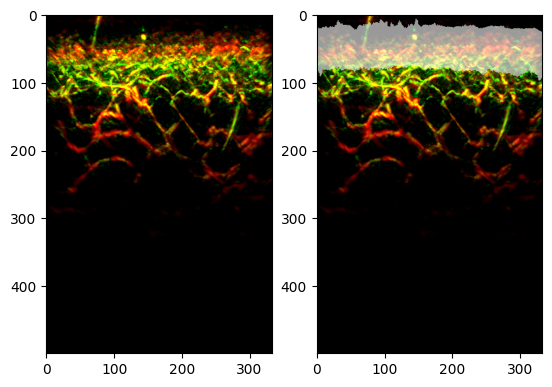

In [9]:
def calculate_segmentation_overlay(mip, segmentation, axis):
    def _overlay(data, seg, alpha, colour=(255, 255, 255)):
        seg_mask = seg.copy()
        seg_mask = np.dstack((seg_mask, seg_mask, seg_mask)).astype(bool)
        seg_rgb = np.dstack((colour[0] * seg, colour[1] * seg, colour[2] * seg))

        ol = (
            (alpha * seg_mask.astype(np.uint8) * data)
            + (np.logical_not(seg_mask).astype(np.uint8) * data)
            + (1 - alpha) * seg_rgb
        )

        return ol.clip(0, 255).astype(np.uint8)

    segmentation = np.amax(segmentation, axis=axis)

    return _overlay(mip, segmentation.astype(np.float32), alpha=0.4)


mip_epidermis_overlay = calculate_segmentation_overlay(mip_rgb, is_epidermis, 1)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(mip_rgb)
ax[1].imshow(mip_epidermis_overlay)
plt.show()

## Vessel Segmentation
### Preprocessing

Post-process the epidermis segmentation mask by smoothing.

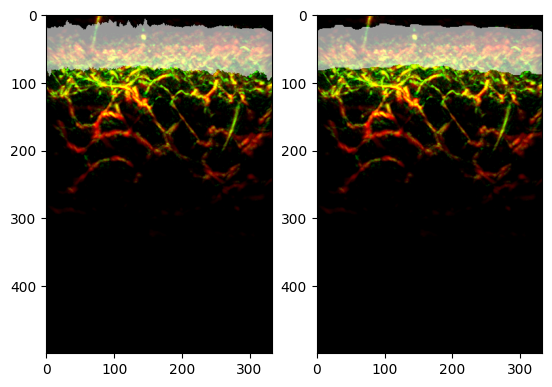

In [10]:
def postprocess_epidermis_seg(vol_):
    vol = copy.deepcopy(vol_)
    vol_shape = vol.shape
    structure = scipy.ndimage.generate_binary_structure(3, 2)

    pad_width = 6
    closing_iter1 = 5
    closing_iter2 = 1
    assert pad_width == closing_iter1 + closing_iter2

    vol = np.pad(vol, pad_width=pad_width, mode="edge")
    vol = scipy.ndimage.binary_closing(
        vol, structure=structure, iterations=closing_iter1, border_value=0
    )
    vol = scipy.ndimage.binary_opening(
        vol, structure=structure, iterations=5, border_value=0
    )
    vol = scipy.ndimage.binary_closing(
        vol, structure=structure, iterations=closing_iter2, border_value=0
    )
    vol = vol[pad_width:-pad_width, pad_width:-pad_width, pad_width:-pad_width]

    assert vol_shape == vol.shape
    return vol


is_epidermis_s = postprocess_epidermis_seg(is_epidermis)

mip_epidermis_overlay_s = calculate_segmentation_overlay(mip_rgb, is_epidermis_s, 1)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(mip_epidermis_overlay)
ax[1].imshow(mip_epidermis_overlay_s)
plt.show()

Mask the epidermis region from the dataset.

In [11]:
def mask_and_cut_epidermis(vol_lf_, vol_hf_, segmentation, offset=10):
    vol_lf = copy.deepcopy(vol_lf_)
    vol_hf = copy.deepcopy(vol_hf_)
    assert (
        vol_lf.shape == segmentation.shape
    ), "Shapes of raw data and segmentation do not match."

    # use projection to 1D to estimate start and end of epidermis in z-direction
    label_sum = np.sum(segmentation.astype(np.float32), axis=(1, 2))

    # normalize
    label_sum /= np.amax(label_sum)

    # define cutoff parameter for layer intensity
    cutoff = 0.05

    label_sum_bin = label_sum > cutoff
    label_sum_idx = np.squeeze(np.nonzero(label_sum_bin))

    # cut at the last index where the sum of segmentation is larger than the cutoff parameter
    # and add an offset parameter

    offset = 10
    layer_end = label_sum_idx[-1] + offset
    
    print("Cutting at", layer_end)
    vol_lf = vol_lf[layer_end:, ...]
    vol_hf = vol_hf[layer_end:, ...]
    return vol_lf, vol_hf


raw_rsom_lf_cropped, raw_rsom_hf_cropped = mask_and_cut_epidermis(
    raw_rsom_lf, raw_rsom_hf, is_epidermis_s
)

Cutting at 91


Prepare the input data for the vessel segmentation.
Create the function to transform the input to a tensor and the inverse function to transform it back to a np.ndarray.

In [12]:
vessel_vol_rgb = prepare_rgb_volume(
    raw_rsom_lf_cropped,
    raw_rsom_hf_cropped,
    upper_bound={"lf": 0.25, "hf": 0.15},
    lower_bound={"lf": 0.05, "hf": 0.05},
)


def get_patch(volume, index, divs=(2, 2, 2), offset=(6, 6, 6)):
    """
    Get subvolume patch from volume
    Args:
        - volume (np.array)         :   The volume to cut
                                        N Dimensions:
                                        single channel   : (X_1,..., X_N)
                                        multi channel    : (X_1,..., X_N, C)
        - index (int)               :   flattened patch iterator.
                                        in range 0 to prod(divs)-1
        - divs (tuple)              :   Amount to divide each dimension
                                        len(divs) must be equal to N
        - offset (tuple)            :   Offset for each div
                                        len(offset) must be equal to N

    Output:
        - patch (np.array)          :   patch at index
    """
    if isinstance(divs, int):
        divs = (divs,)
    if isinstance(offset, int):
        offset = (offset,)

    assert len(volume.shape) == len(divs) or len(volume.shape) == len(divs) + 1
    assert len(volume.shape) == len(offset) or len(volume.shape) == len(offset) + 1

    if len(volume.shape) == len(divs) + 1:
        # multi channel
        shape = volume.shape[:-1]
    else:
        # single channel
        shape = volume.shape

    if np.any(np.mod(shape, divs)):
        warnings.warn(
            (
                "At least one dimension of the input volume can't be "
                "divided by divs without remainder. Your input shape "
                "and reconstructed shapes won't match."
            )
        )

    widths = [int(s / d) for s, d in zip(shape, divs)]
    patch_shape = [w + o * 2 for w, o in zip(widths, offset)]

    # create nd index
    index_ = np.unravel_index(index, divs)

    # coordinates
    c = [s * d for s, d in zip(index_, widths)]

    if len(volume.shape) == len(divs) + 1:
        patch_shape = tuple(patch_shape + [volume.shape[-1]])
    else:
        patch_shape = tuple(patch_shape)

    patch = np.zeros(patch_shape, dtype=volume.dtype)

    s_ = []
    e_ = []
    slice_idx = []
    slice_idx_patch = []
    # for every dimension X_1 ... X_N
    for dim in np.arange(len(c)):
        # calculate start and end index of the patch
        s_ = c[dim] - offset[dim] if c[dim] - offset[dim] >= 0 else 0
        e_ = (
            c[dim] + widths[dim] + offset[dim]
            if c[dim] + widths[dim] + offset[dim] <= shape[dim]
            else shape[dim]
        )
        slice_idx.append(slice(s_, e_))

        # start and end index considering offset
        ps_ = offset[dim] - (c[dim] - s_)
        pe_ = ps_ + (e_ - s_)
        slice_idx_patch.append(slice(ps_, pe_))

    slice_idx = tuple(slice_idx)
    slice_idx_patch = tuple(slice_idx_patch)

    # cut out current patch
    vp = volume[slice_idx]

    # for offset
    patch[slice_idx_patch] = vp
    return patch


def get_volume(patches, divs = (2,2,3), offset=(6,6,6)):
    '''
    Args:
        - patches (np.array)         :  The patches to reconstruct. N_P patches
                                        are stacked along first dimension.
                                        single channel : (N_P, X_1,..., X_N)
                                        multi channel  : (N_P, X_1,..., X_N, C)
        - divs (tuple)              :   Amount to divide each dimension
                                        len(divs) must be equal to N 
        - offset (tuple)            :   Offset for each div
                                        len(offset) must be equal to N
                                      
    Output:
        - volume  (np.array)        :   patches reconstructed to volume
                                        single channel : (X_1,..., X_N)
                                        multi channel  : (X_1,..., X_N, C)
    '''
    if isinstance(divs, int):
        divs = (divs,)
    if isinstance(offset, int):
        offset = (offset,)

    new_shape = [(ps -of*2)*int(d) \
                 for ps, of, d in zip(patches.shape[1:], offset, divs)]
    
    if len(patches.shape) == len(divs) + 2:
        # multi channel
        new_shape = tuple(new_shape + [patches.shape[-1]])
    else:
        # single channel
        new_shape = tuple(new_shape)
    
    volume = np.zeros(new_shape, dtype=patches.dtype)
    shape = volume.shape
    widths = [int(s/d) for s, d in zip(shape, divs)]
    # iterate over patch indices
    for index in np.arange(np.prod(divs)):
        index_ = np.unravel_index(index, divs)
        slice_idx = []
        slice_idx_offs = []
        # iterate over dimension X_1 ... X_N
        for dim in np.arange(len(index_)):
            # calculate start and end index inside volume
            s_ = (index_[dim] * widths[dim])
            e_ = ((index_[dim] + 1) * widths[dim])
            slice_idx.append(slice(s_, e_))
            
            # calculate start and end index inside patch,
            # to ret rid of the offset
            ps_ = offset[dim]
            pe_ = offset[dim] + widths[dim]
            slice_idx_offs.append(slice(ps_, pe_))
            
        patch = patches[index,...]
        volume[tuple(slice_idx)] = patch[tuple(slice_idx_offs)]
    return volume


def prepare_tensor_vesselseg_patches(data, divs):
    offset = (6, 6, 6)

    initial_shape = data.shape
    
    patches = []
    crop = {}
    
    # crop data in order to be dividable by divs
    rem = np.mod(data.shape[: len(divs)], divs)
    assert len(rem) == 3, "Other cases are not implemented. In general our data is 3D."

    if rem[0]:
        data = data[int(np.floor(rem[0] / 2)) : -int(np.ceil(rem[0] / 2)), ...]

    if rem[1]:
        data = data[:, int(np.floor(rem[1] / 2)) : -int(np.ceil(rem[1] / 2)), ...]

    if rem[2]:
        data = data[:, :, int(np.floor(rem[2] / 2)) : -int(np.ceil(rem[2] / 2)), ...]

    # add to meta information, how much has been cropped
    crop["begin"] = torch.from_numpy(
        np.array(
            [np.floor(rem[0] / 2), np.floor(rem[1] / 2), np.floor(rem[2] / 2), 0],
            dtype=int,
        )
    )
    crop["end"] = torch.from_numpy(
        np.array(
            [np.ceil(rem[0] / 2), np.ceil(rem[1] / 2), np.ceil(rem[2] / 2), 0],
            dtype=int,
        )
    )

    assert np.all(
        np.array(initial_shape)
        == crop["begin"].numpy()
        + crop["end"].numpy()
        + np.array(data.shape)
    ), "Shapes and Crop do not match"

    for idx in range(np.prod(divs)):
        patch_data = get_patch(data, idx, divs, offset)
        patch_data_tensor = torch.from_numpy(np.moveaxis(patch_data[..., :2], -1, 0))
        patch_data_tensor = torch.unsqueeze(patch_data_tensor, 0)
        patches.append(patch_data_tensor)
    return patches, crop


def prepare_tensor_vesselseg(data_):
    data = np.pad(data_, ((6, 6), (6, 6), (6, 6), (0, 0)), "constant")
    data_tensor = torch.from_numpy(np.moveaxis(data[..., :2], -1, 0))
    return torch.unsqueeze(data_tensor, 0)


def to_numpy_ves(volume):
    if isinstance(volume, torch.Tensor):
        volume = volume.numpy()

    # removes batch and channel dim
    volume = np.squeeze(volume)

    return np.ascontiguousarray(volume)


# smaller GPUS have to use patches
vesselseg_use_patches = True

if vesselseg_use_patches:
    divs = (1, 1, 2)
    data_ves, crop = prepare_tensor_vesselseg_patches(vessel_vol_rgb, divs)
else:
    data_ves = prepare_tensor_vesselseg(vessel_vol_rgb)
    # data_ves.shape


### Vessel Segmentation Model

Define the DeepVesselNet.

In [13]:
class DeepVesselNet(nn.Module):
    def __init__(
        self,
        channels=(2, 5, 10, 20, 50, 1),
        kernels=(3, 5, 5, 3, 1),
        groupnorm=True,
        depth=5,
    ):
        super(DeepVesselNet, self).__init__()

        self.depth = depth

        # generate channels list for every layer
        self.channels = channels

        # generate kernel size list
        self.kernels = kernels

        if groupnorm:
            self.groupnorms = [0] + [1] * (depth - 2) + [0]
        else:
            self.groupnorms = [0] * depth

        assert len(self.channels) == depth + 1
        assert len(self.kernels) == depth
        assert len(self.groupnorms) == depth

        layers = []

        # deep layers
        for i in range(depth - 1):
            layers.append(
                DVN_Block(
                    self.channels[i],
                    self.channels[i + 1],
                    self.kernels[i],
                    self.groupnorms[i],
                )
            )
        # last layer
        layers.append(nn.Conv3d(self.channels[-2], self.channels[-1], self.kernels[-1]))

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


class DVN_Block(nn.Module):
    def __init__(self, in_size, out_size, kernel_size, groupnorm):
        super(DVN_Block, self).__init__()

        block = []

        block.append(nn.Conv3d(in_size, out_size, kernel_size))
        block.append(nn.ReLU())
        if groupnorm:
            block.append(nn.GroupNorm(5, out_size))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        return self.block(x)


model = DeepVesselNet()
model.load_state_dict(torch.load(model_file_vesselseg))

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Override the device if your GPU doesn't have enough memory.

In [14]:
device = "cpu"

In [15]:
# cuda_dtype = torch.bfloat16
cuda_dtype = torch.float32

model.to(device, cuda_dtype)

DeepVesselNet(
  (layers): Sequential(
    (0): DVN_Block(
      (block): Sequential(
        (0): Conv3d(2, 5, kernel_size=(3, 3, 3), stride=(1, 1, 1))
        (1): ReLU()
      )
    )
    (1): DVN_Block(
      (block): Sequential(
        (0): Conv3d(5, 10, kernel_size=(5, 5, 5), stride=(1, 1, 1))
        (1): ReLU()
        (2): GroupNorm(5, 10, eps=1e-05, affine=True)
      )
    )
    (2): DVN_Block(
      (block): Sequential(
        (0): Conv3d(10, 20, kernel_size=(5, 5, 5), stride=(1, 1, 1))
        (1): ReLU()
        (2): GroupNorm(5, 20, eps=1e-05, affine=True)
      )
    )
    (3): DVN_Block(
      (block): Sequential(
        (0): Conv3d(20, 50, kernel_size=(3, 3, 3), stride=(1, 1, 1))
        (1): ReLU()
        (2): GroupNorm(5, 50, eps=1e-05, affine=True)
      )
    )
    (4): Conv3d(50, 1, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  )
)

Define the inference function and run the vessel segmentation prediction.

In [16]:
def predict(data, model):
    pred_tensor = model(data.to(device, cuda_dtype)).detach().to("cpu")
    prob_tensor = torch.sigmoid(pred_tensor)
    return to_numpy_ves(prob_tensor)

def predict_patches(data, model, crop):
    patches = []
    for patch in data:
        pred = model(patch.to(device, cuda_dtype)).detach().to("cpu")
        prob = torch.sigmoid(pred)
        patches.append(to_numpy_ves(prob))

    
    prob_volume = get_volume(np.stack(patches, axis=0), divs=divs, offset=(0, 0, 0))

    b = crop['begin']
    e = crop['end']

    pad_width = ((b[0], e[0]), (b[1], e[1]), (b[2], e[2]))
    
    prob_volume = np.pad(prob_volume, pad_width, 'edge')
    
    assert prob_volume.shape[1] == 171
    assert prob_volume.shape[2] == 333

    return prob_volume


if vesselseg_use_patches:
    prediction = predict_patches(data_ves, model, crop)
else:
    prediction = predict(data_ves, model)


is_vessel = prediction >= 0.95

pad_shape = list(is_vessel.shape)
pad_shape[0] = raw_rsom_lf.shape[0] - pad_shape[0]

is_vessel = np.concatenate([np.zeros(pad_shape, dtype=is_vessel.dtype), is_vessel])

assert is_vessel.shape == is_epidermis.shape == raw_rsom_lf.shape == raw_rsom_hf.shape

### Vessel Segmentation Results

Visualize the vessel segmentation results in 2D.

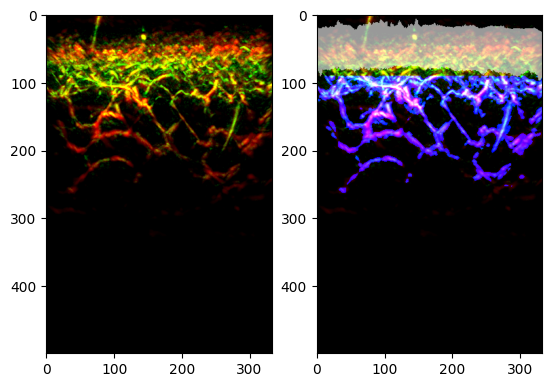

In [17]:
mip_epidermis_vessel_overlay = copy.deepcopy(mip_epidermis_overlay)
mip_epidermis_vessel_overlay[..., 2] += 255 * np.max(is_vessel, axis=1).astype(np.uint8)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(mip_rgb)
ax[1].imshow(mip_epidermis_vessel_overlay)
plt.show()

## Feature Extraction

Note: The paper restricts the extraction of vascular features to a Region Of Interest (ROI), especially to exclude misclassifications in the upper dermal part. In high-quality samples like this one, we are able to extract vascular features from the entire vessel segmentation mask.

In [18]:
ves_seg = is_vessel
ep_seg = is_epidermis_s

We specify the following configuration parameters in a python dict.

| Parameter             | Description|
|:---------------------------|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| min_size                   | Vessel Segmentation: Objects with a volume smaller than `min_size` pixels are removed from the vessel segmentation to maintain large independent vessels solely.                                                                                |
| min_component_length       | Metric Graph: Connected components smaller than `min_component_length` pixels are removed from the metric graph to discard small unpaired artifacts.                                                                                    |
| min_end_branch_length      | Metric Graoh: We remove ending branches of the metric graph smaller than `min_end_branch_length` pixel to capture the actual underlying topology better.                                                                             |
| delta      | Metric Graph: Delta relates to the construction of the Rips-Vietoris graph. Rips-Vietoris graph is an abstract simplicial complex that can be defined from any metric space and distance `delta` by forming a simplex for every finite set of points that has diameter at most `delta`. (For further details [click here](https://www.jmlr.org/papers/volume15/lecci14a/lecci14a.pdf))  |
| r      | Metric Graph: The radius `r` of the shell that is constructed around each point. (For further details [click here](https://www.jmlr.org/papers/volume15/lecci14a/lecci14a.pdf)) |
| p11      | Metric Graph: The Euclidean distance `p11` within which all points from a preliminary vertex point are labeled as vertices. (For further details [click here](https://www.jmlr.org/papers/volume15/lecci14a/lecci14a.pdf)) |
| save_features_csv_path      | Results: The path where to save the features csv to. |


In [30]:
config = {"min_size": 1000,
          "min_comp_length": 50,
          "min_end_branch_length": 20,
          "delta": 2,
          "r": 1.5,
          "p11": 0.9,
          "save_features_json_path": "./features.json"}

Construct a python dictionary to store extracted volumetric and graph features.

In [20]:
features = dict()
features["volumetric"] = dict()
features["graph"] = dict()

### Extract Volumetric Features

Preprocess segmentation mask.

In [21]:
ves_seg_clean = skimage.morphology.remove_small_objects(ves_seg.astype(bool), config["min_size"])

Extract volumetric features directly from the vessel and the epidermis segmentation mask:

|Feature|Description|Unit|
|-------|-----------|----|
|total_blood_volume|Volume of the vessel segmentation mask|µm³|
|epidermis_width|Average width in z-direction of the epidermis segmentation mask|µm³|

In [22]:
features["volumetric"]["total_blood_volume"] = ves_seg_clean.sum() * 12 * 12 * 3
features["volumetric"]['epidermis_width'] = ((ep_seg.sum() / ep_seg.shape[1]) / ep_seg.shape[2]) * 3

### Extract Graph Features

First, extract the skeleton from the vessel segmentation mask.

In [23]:
def extract_vessel_radii(vol):
    """
    Extract vessel radii from volume.
    """
    vol_clean = scipy.ndimage.binary_closing(vol, iterations=2).astype(np.uint8)
    vol_clean = np.asarray(scipy.ndimage.binary_fill_holes(vol_clean), dtype='uint8')
    skeleton = skimage.morphology.skeletonize_3d(vol_clean).astype(dtype='uint8')
    transf = scipy.ndimage.distance_transform_edt(vol_clean, return_indices=False)
    radii = transf * skeleton
    return radii

vessel_radii = extract_vessel_radii(ves_seg)

Now, we extract the metric graph from the skeleton. Note that this implementation bases on the 2d implementation from:
* github: https://github.com/markolalovic/metric-graph-reconstruction
* author: @markolalovic

Note: This is an expensive operation and may take up to 4h per sample.

In [24]:
def timing(func):
    """
    timing decorator
    Args:
        func: function handle

    Returns: timing function wrapper

    """
    def wrapper(*arg, **kw):
        t1 = time.time()
        res = func(*arg, **kw)
        t2 = time.time()
        print(func.__name__, 'took', t2 - t1, 's')
        return res

    return wrapper

class EmbeddedGraph:
    def __init__(self, nodes, edges, radius=[]):
        """
        Graph with points embedded in the plane.
        """
        self.nodes = PointList(nodes)
        self.edges = [PointList(edge) for edge in edges]
        self.radius = radius

    def __str__(self):
        points = [str(point) for point in self.nodes.points]
        edges = [str(edge) for edge in self.edges]
        components = [str(cmpt_emb_G) for cmpt_emb_G in self.components.values()]

        return "nodes: {}\edges: {}\ncomponents: {}".format(
            str(points), str(edges), str(components))

    def to_dict(self):
        """ Converts EmbeddedGraph to dict."""
        points = [point.to_tuple() for point in self.nodes.points]
        edges = [edge.to_list() + [r] for edge, r in zip(self.edges, self.radius)]
        components = [cmpt_emb_G.to_list() for cmpt_emb_G in self.components.values()]

        embedded_graph = dict()
        embedded_graph["points"] = points
        embedded_graph["edges"] = edges
        embedded_graph["components"] = components

        return embedded_graph

    @property
    def n(self):
        """ Number of nodes in EmbeddedGraph."""
        return len(self.nodes.points)

    @property
    def m(self):
        """ Number of edges in EmbeddedGraph."""
        return len(self.edges)

    @property
    def k(self):
        """ Number of connected components of EmbeddedGraph."""
        return len(self.components)

    @property
    def components(self):
        """ Computes connected components of EmbeddedGraph"""
        graph_G = graph(self)
        cmpts_G = graph_G.components

        cmpts_emb_G = {}
        point_of = {}
        for i in range(self.n):
            point_of[i] = self.nodes.points[i]

        for i, cmpt_G in cmpts_G.items():
            cmpts_emb_G[i] = PointList([point_of[j] for j in cmpt_G])

        return cmpts_emb_G


class Graph:
    def __init__(self, nodes, edges):
        """ Graph represented with nodes and edges."""
        if isinstance(nodes, list):
            self.nodes = nodes
        else:
            self.nodes = list(nodes)
        if isinstance(edges, list):
            self.edges = edges
        else:
            self.edges = list(edges)

    @property
    def n(self):
        """ Number of nodes in Graph."""
        return len(self.nodes)

    @property
    def m(self):
        """ Number of edges in Graph."""
        return len(self.edges)

    @property
    def k(self):
        """ Number of connected components of Graph."""
        return len(self.components)

    @property
    def components(self):
        """ Computes connected components of Graph"""
        cmpts = {}
        k = 0
        unvisited = copy.copy(self.nodes)
        for v in self.nodes:
            if v in unvisited:
                comp_of_v = component(v, self.nodes, self.edges)
                # remove visited nodes in component from unvisited
                unvisited = list(set(unvisited) - set(comp_of_v))
                cmpts[k] = comp_of_v
                k += 1

        return cmpts

    def __str__(self):
        return "nodes: {}\nedges: {}".format(str(self.nodes), str(self.edges))


def nhbs(v, graph_G):
    N = []
    for edge in graph_G.edges:
        u1, u2 = edge
        if u1 == v:
            N.append(u2)
        elif u2 == v:
            N.append(u1)
    return N


def component(v, nodes, edges):
    """ Wrapper of comp."""
    G = Graph(nodes, edges)
    return comp(v, G, [v])  # T=[v] at the start


def comp(v, graph_G, T):
    N = list(set(nhbs(v, graph_G)) - set(T))
    if N == []:
        return [v]
    else:
        T += N  # expand the tree
        for n in N:
            T += comp(n, graph_G, T)  # expand the tree (BFS)
    return list(set(T))


def graph(emb_G):
    """ Translate from EmbeddedGraph to Graph."""

    point_of = {}
    for i in range(emb_G.n):
        point_of[i] = emb_G.nodes.points[i]

    number_of = {}
    for i in range(emb_G.n):
        number_of[emb_G.nodes.points[i]] = i

    nodes = list(point_of.keys())
    edges = []
    for i in range(emb_G.n):
        for j in range(i + 1, emb_G.n):
            # test if there is an edge between Points v1 and v2
            v1 = emb_G.nodes.points[i]
            v2 = emb_G.nodes.points[j]

            for edge in emb_G.edges:
                u1 = edge.points[0]
                u2 = edge.points[1]
                if v1.equal(u1) and v2.equal(u2) or \
                        v1.equal(u2) and v2.equal(u1):
                    edges.append((number_of[v1], number_of[v2]))

    return Graph(nodes, edges)


class Point:
    """ Class Point for storing coordinates and label of a point.

    Args:
        x::float
            The x coordinate of the point.
        y::float
            The y coordinate of the point.
        label::str
            Should be: 'E' for edge point and 'V' for vertex point.
    """

    def __init__(self, x=0, y=0, z=0, radius=0, label=''):
        self.x = x
        self.y = y
        self.z = z
        self.radius = radius
        if label not in ('E', 'V', ''):
            raise ValueError("Label must be 'E' or 'V'")
        self.label = label

    def __str__(self):
        return "({}, {}, {})".format(self.x, self.y, self.z, self.label)

    def to_tuple(self):
        """Converts Point to tuple."""
        return self.x, self.y, self.z

    def equal(self, p):
        return (self.x == p.x) and (self.y == p.y) and (self.z == p.z)


class PointList:
    def __init__(self, points):
        """ PointList Class to hold a list of Point objects."""
        if points == [] or isinstance(points[0], Point):
            self.points = points
        else:
            raise ValueError("Args must be a list of Points.")

    @property
    def vertex_points(self):
        vertex_points = []
        for point in self.points:
            if point.label == 'V':
                vertex_points.append(point)

        return vertex_points

    @property
    def edge_points(self):
        edge_points = []
        for point in self.points:
            if point.label == 'E':
                edge_points.append(point)

        return edge_points

    @property
    def center(self):
        """ Center of mass of the point cloud."""
        x = np.mean(np.array([point.x for point in self.points]))
        y = np.mean(np.array([point.y for point in self.points]))
        z = np.mean(np.array([point.z for point in self.points]))
        radius = np.mean(np.array([point.radius for point in self.points]))

        return Point(x, y, z, radius)

    def __str__(self):
        return '[' + ','.join(['{!s}'.format(p) for p in self.points]) + ']'

    def to_list(self):
        """Converts PointList to list."""
        return [p.to_tuple() for p in self.points]

    def __len__(self):
        return len(self.points)

    def contains(self, p):
        for pt in self.points:
            if pt.x == p.x and pt.y == p.y and pt.z == p.z:
                return True
        return False

    def append(self, p):
        self.points.append(p)

    def difference(self, pl):
        difference = PointList([])
        for pt in self.points:
            if not pl.contains(pt):
                difference.append(pt)
        return difference

    def distance(self, point_list):
        ''' Computes minimum distance from self to another point list.'''
        distances = []
        for p1 in self.points:
            for p2 in point_list.points:
                distances.append(distance(p1, p2))

        return np.min(np.array(distances))

    def avg_radius(self):
        radius = []
        for p in self.points:
            radius.append(p.radius)
        return np.array(radius).mean()


def distance(p1, p2):
    """ Euclidean distance between p1, p2."""
    d = (
            ((p1.x - p2.x) ** 2) +
            ((p1.y - p2.y) ** 2) +
            ((p1.z - p2.z) ** 2)
        ) ** 0.5
    return d


def get_shell_points(points, center, r, delta):
    """ Returns a list of points between r and r + delta around the center
    point."""
    shell_points = []
    for point in points:
        d = distance(center, point)
        if d >= r and d <= r + delta:
            shell_points.append(point)

    return shell_points


def get_ball_points(points, center, r):
    ball_points = []
    for point in points:
        d = distance(center, point)
        if d < r:
            ball_points.append(point)

    return ball_points


def rips_vietoris_graph(delta, points):
    """ Constructs the Rips-Vietoris graph of parameter delta whose nodes
    are points of the shell."""
    n = len(points)
    nodes = []
    edges = []
    for i in range(n):
        p1 = points[i]
        nodes.append(p1)
        for j in range(i, n):
            p2 = points[j]
            if not p1.equal(p2) and distance(p1, p2) < delta:
                edges.append([p1, p2])

    return EmbeddedGraph(nodes, edges)

def volume_to_point_list(vol):
    """
    Construct PointList instance from volume.
    """
    # flip z-axis for coordinate system conversion
    vol = np.flip(vol, 0)
    # get shapes, note that we need to configure x-y-z ordering
    x = vol.shape[2]
    y = vol.shape[1]
    z = vol.shape[0]
    # list of points
    points = []
    for x_idx in range(x):
        for y_idx in range(y):
            for z_idx in range(z):
                radius = vol[z_idx, y_idx, x_idx]
                if radius > 0.:
                    points.append(Point(x_idx, y_idx, z_idx, round(radius, 3)))
    return PointList(points)

@timing
def reconstruct_graph(point_list, delta, r, p11):
    """
    Implementation of Aanjaneya's metric graph reconstruction algorithm.
    """

    # label the points as edge or vertex points
    for center in point_list.points:
        shell_points = get_shell_points(point_list.points, center, r, delta)
        rips_embedded = rips_vietoris_graph(delta, shell_points)

        if rips_embedded.k == 2:
            center.label = 'E'
        else:
            center.label = 'V'

    # re-label all the points withing distance p11 from vertex points as vertices
    for center in point_list.vertex_points:
        ball_points = get_ball_points(point_list.edge_points, center, p11)
        for ball_point in ball_points:
            ball_point.label = 'V'

    # reconstruct the graph structure
    # compute the connected components of Rips-Vietoris graphs:
    # R_delta(vertex_points), R_delta(edge_points)
    rips_V = rips_vietoris_graph(delta, point_list.vertex_points)
    rips_E = rips_vietoris_graph(delta, point_list.edge_points)
    cmpts_V = rips_V.components

    # takes a long time
    cmpts_E = rips_E.components

    nodes_emb_G = []
    for i, cmpt_V in cmpts_V.items():
        nodes_emb_G.append(cmpt_V.center)
    n = len(nodes_emb_G)
    edges_emb_G = []
    radius = []
    for i in range(n):
        for j in range(i + 1, n):
            for cmpt_E in cmpts_E.values():
                if cmpts_V[i].distance(cmpt_E) < delta and \
                        cmpts_V[j].distance(cmpt_E) < delta:
                    edges_emb_G.append([nodes_emb_G[i], nodes_emb_G[j]])
                    radius.append(cmpt_E.avg_radius())

    emb_G = EmbeddedGraph(nodes_emb_G, edges_emb_G, radius)
    return emb_G

point_list = volume_to_point_list(vessel_radii)
metric_graph = reconstruct_graph(point_list, config["delta"], config["r"], config["p11"]) # 10840s on M1 Pro
metric_graph_dict = metric_graph.to_dict()

reconstruct_graph took 7012.371670007706 s


We now cast the metric graph class structure to a [networkx](https://networkx.org/) graph instance.

In [25]:
graph = nx.Graph()
nodes = [tuple(n) for n in metric_graph_dict["points"]]
edges = [[tuple(e) for e in edge[:2]] + [edge[2]] for edge in metric_graph_dict["edges"]]
graph.add_weighted_edges_from(edges, weight='radius')
graph.add_nodes_from(nodes)

We then preprocess the metric graph.

In [26]:
def compute_distance(p1, p2, mc=True):
    """
    Euclidean distance between tuples p1 and p2.

    Args:
        p1: point 1 represented as tuple: (x, y, z)
        p2: point 2 represented as tuple: (x, y, z)
        mc: whether to compute distance in micrometer (given a RSOM pixel space).
    """
    # step size of RSOM laser in x, y, and z direction
    step_size_mc = (12, 12, 3)
    if not mc:
        step_size_mc = (1, 1, 1)
    # euclidean distance computation
    d = (
                (((p1[0]-p2[0]) * step_size_mc[0]) ** 2) +
                (((p1[1]-p2[1]) * step_size_mc[1]) ** 2) +
                (((p1[2]-p2[2]) * step_size_mc[2]) ** 2)
        ) ** 0.5
    return d
# remove components smaller than min_comp_length
graph_clean = nx.Graph()
for c in nx.connected_components(graph):
    distance = 0
    g = graph.subgraph(c)
    for edge in g.edges:
        distance += compute_distance(edge[0], edge[1], mc=False)
    if distance > config["min_comp_length"]:
        graph_clean = nx.compose(graph_clean, g)
# remove end-branches smaller than min_end_branch_length
edges_to_remove = []
for e in graph_clean.edges():
    if compute_distance(e[0], e[1], mc=False) < config["min_end_branch_length"]:
        if graph_clean.degree(e[0]) == 1 or graph_clean.degree(e[1]) == 1:
            edges_to_remove.append(e)
graph_clean.remove_edges_from(edges_to_remove)
# remove isolated nodes eventually caused by previous edge removal
graph_clean.remove_nodes_from(list(nx.isolates(graph_clean)))

We visualize the preprocessed metric graph.

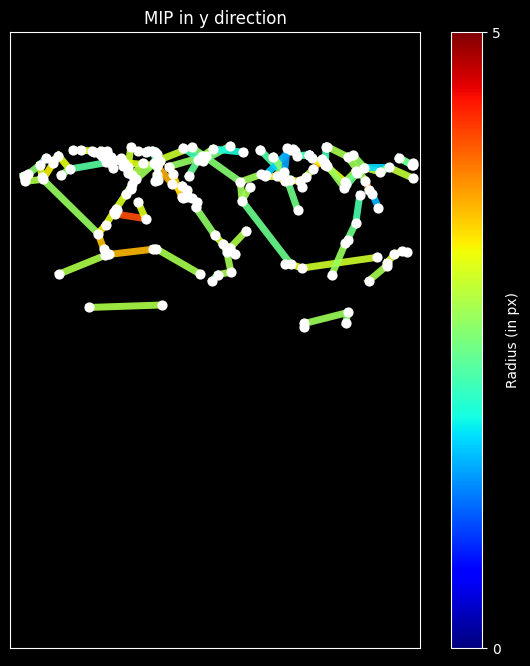

In [27]:
def visualize_metric_graph(metric_graph, axis="x"):
    """
    Visualizes metric graph as MIP.

    Args:
        graph (networkx.graph): the graph as networkx graph instance
        axis (str): the axis we project: x, y or z (defaults to "x")
    """
    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=(8, 8))
    radii = np.array([e[2]["radius"] for e in graph_clean.edges(data=True)])
    sm = ScalarMappable(cmap='jet', norm=plt.Normalize(0, 5))
    sm.set_array(radii)
    
    for e in metric_graph.edges(data=True):
        radius = e[2]["radius"]
        if axis == "x":
            edge = ax.plot([y for x, y, z in e[:2]], [z for x, y, z in e[:2]], linewidth=5, alpha=0.9)
        elif axis == "y":
            edge = ax.plot([x for x, y, z in e[:2]], [z for x, y, z in e[:2]], linewidth=5, alpha=0.9)
        elif axis == "z":
            edge = ax.plot([x for x, y, z in e[:2]], [y for x, y, z in e[:2]], linewidth=5, alpha=0.9)
        else:
            raise ValueError("Wrong axis specified.")
        edge[0].set_color(sm.to_rgba(radius))
        
    if axis == "x":
        ax.scatter([y for x, y, z in metric_graph.nodes], [z for x, y, z in graph_clean.nodes], c="white", s=40, zorder=2.5)
        xmax=171
        ymax=500
    elif axis == "y":
        ax.scatter([x for x, y, z in metric_graph.nodes], [z for x, y, z in graph_clean.nodes], c="white", s=40, zorder=2.5)
        xmax=333
        ymax=500
    elif axis == "z":
        ax.scatter([x for x, y, z in metric_graph.nodes], [y for x, y, z in graph_clean.nodes], c="white", s=40, zorder=2.5)
        xmax=333
        ymax=171
    else:
        raise ValueError("Wrong axis specified.")
        
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.set_ylim(ymin=0, ymax=ymax)
    ax.set_xlim(xmin=0, xmax=xmax)
    ax.set_title(f"MIP in {axis} direction")
    cbar = plt.colorbar(sm, ax=ax, ticks=[0, 5], label='Radius (in px)')
    ax.set_box_aspect(ymax/xmax)
        
visualize_metric_graph(graph_clean, axis="y")

Finally, we extract vascular features from the prepocessed metric graph (`G`). Main features are:


|Feature|Description|Unit|
|:-------|:-----------|:----|
|total_vessel_length|Sum of the length of edges of `G`|mm|
|small_vessel_length|Sum of the length of edges of `G` having an average radius smaller than 2.5 pixels|mm|
|large_vessel_length|Sum of the length of edges of `G` having an average radius greater than or equal to 2.5 pixels|mm|
|#vessel_bifurcations|Number of nodes of `G` with a degree higher than 2|-|


Experimental features include: 

|Feature|Description|Unit|
|:--------|:----------|:----|
| num_components| Number of connected components of `G`|-|
| length_per_component| Average length of the edges per connected component of `G`|mm|
| density| [Density](https://networkx.org/documentation/stable/reference/generated/networkx.classes.function.density.html) of `G`|-|
| degree_assortativity_coefficient | Measures the similarity of connections in the graph with respect to the node degree ([source](https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.algorithms.assortativity.degree_assortativity_coefficient.html#networkx.algorithms.assortativity.degree_assortativity_coefficient))|-|
| num_cycles| Number of cycles of `G`|-|
| avg_radius| Average radius of `G`'s edges|pixel|
| avg_path_length|Average shortest path length from eacz node to every other node of `G`|mm|                                                                                        

In [28]:
# average path length in mm
path_lengths = []
for v in graph_clean.nodes():
    spl = dict(nx.single_source_shortest_path_length(graph_clean, v))
    for p in spl:
        path_lengths.append(spl[p])
features['graph']['avg_path_length'] = np.mean(path_lengths) / 1000

# density
features['graph']['density'] = nx.density(graph_clean)

# degree assortativity coefficient
degree_assortativity_coefficient = nx.degree_assortativity_coefficient(graph_clean)
if degree_assortativity_coefficient is None:
    degree_assortativity_coefficient = 0
features['graph']['degree_assortativity_coefficient'] = degree_assortativity_coefficient

# number of cycles
features['graph']['num_cycles'] = len(nx.cycle_basis(graph_clean))

# number of bifurcation points
features['graph']['num_vessel_bifurcations'] = len([val for (node, val) in graph_clean.degree() if val > 2])

# number of components
features['graph']['num_components'] = nx.number_connected_components(graph_clean)

# average length per component in mm
len_components = []
for c in nx.connected_components(graph_clean):
    distance = 0
    g = graph_clean.subgraph(c)
    for edge in g.edges:
        distance += compute_distance(edge[0], edge[1])
    len_components.append(distance)
len_components = np.array(len_components)
features['graph']['length_per_component'] = len_components.mean() / 1000

# total length of metric graph in mm
features['graph']['total_vessel_length'] = len_components.sum() / 1000

# average radius in px
features['graph']['avg_radius'] = np.array([e[2]["radius"] for e in graph_clean.edges(data=True)]).mean()

# length of small and large vessels in mm
small_vessel_length = 0
large_vessel_length = 0
for e in graph_clean.edges(data=True):
    if e[2]["radius"] <= 2.5:
        small_vessel_length += compute_distance(e[0], e[1])
    else:
        large_vessel_length += compute_distance(e[0], e[1])
small_vessel_length /= 1000
large_vessel_length /= 1000
features['graph']['small_vessel_length'] = small_vessel_length
features['graph']['large_vessel_length'] = large_vessel_length

We print the features and dump them to disk.

In [31]:
features["graph"] = {k: str(v) for k, v in features["graph"].items()}
features["volumetric"] = {k: str(v) for k, v in features["volumetric"].items()}
features_str = json.dumps(features, indent=2)
print(features_str)
with open(config["save_features_json_path"], 'w') as fd:
    fd.write(features_str)

{
  "volumetric": {
    "total_blood_volume": "91693296",
    "epidermis_width": "152.97102365523418"
  },
  "graph": {
    "avg_path_length": "0.018640696473365796",
    "density": "0.011235233692860811",
    "degree_assortativity_coefficient": "-0.1500988096879465",
    "num_cycles": "7",
    "num_vessel_bifurcations": "41",
    "num_components": "9",
    "length_per_component": "3.6235592036686888",
    "total_vessel_length": "32.612032833018205",
    "avg_radius": "2.8863543099150646",
    "small_vessel_length": "7.844180176209212",
    "large_vessel_length": "24.767852656808987"
  }
}
